In [1]:
# Standard library
import os
import sys
import re
import json
import pickle
import glob
import ast
import warnings
from pathlib import Path
import importlib

# Add custom path
sys.path.append('/root/capsule/code/beh_ephys_analysis')

# Scientific libraries
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import xarray as xr
import scipy.signal as signal
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# SpikeInterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw

# Progress bar
from tqdm import tqdm

# IPython display
from IPython.display import clear_output

# Open Ephys
from open_ephys.analysis import Session

# AIND analysis and utils
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align, sort

# Local utilities
import utils.analysis_funcs as af
import utils.plotting_funcs as pf
from utils.beh_functions import session_dirs
# from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar, merge_pdfs

# Warnings
warnings.filterwarnings("ignore")

# Matplotlib inline for Jupyter
%matplotlib inline

# Confirm version
print(si.__version__)
print('Finished loading packages')

2.1.3
2.2.3
0.102.1
Finished loading packages


In [2]:
from antidromic_funcs import antidromic_latency_jitter, collision_test, plot_opto_responses, analyze_antidromic_responses
import importlib
import antidromic_funcs
importlib.reload(antidromic_funcs)
from antidromic_funcs import antidromic_latency_jitter, collision_test, plot_opto_responses, analyze_antidromic_responses

from extract_raw_traces_func import extract_trial_df
# importlib.reload(extract_raw_traces_func)

In [4]:
session = 'behavior_761038_2025-04-16_10-39-10'
session_dir = session_dirs(session)
session_dir

OSError: [Errno 30] Read-only file system: '/root/capsule/data/LC-NE_scratch_data_06-14-2025/behavior_761038_2025-04-16_10-39-10_raw_data'

In [13]:
importlib.reload(antidromic_funcs)
from antidromic_funcs import antidromic_latency_jitter, collision_test, plot_opto_responses, analyze_antidromic_responses, Avg_y_over_x

## Load session data 
# Local path to the root folder containing the session data
# root_folder = rf'D:\Ephys\OptoTaggingAnalysis\antidromic'
root_folder = '/root/capsule/data/LC-NE_scratch_data_06-14-2025'

# session_list = [folder.name for folder in Path(root_folder).glob('7*/behavior_*') if folder.is_dir()]
# session_assets = pd.read_csv(r'D:\Ephys\OptoTaggingAnalysis\antidromic\session_assets.csv')
# session_list = session_assets['session_id']

# concatenate_antidromic_results = pd.DataFrame()

session = 'behavior_761038_2025-04-16_10-39-10'
# session_dir = session_dirs(session)
subject_id = session.split('_')[1]
session_id = '_'.join(session.split('_')[1:3])
print(session_id)

# session_dirs(session)

data_type = 'curated'
target = 'soma'
opto_data_folder = rf'{root_folder}/{subject_id}/{session}/ephys/opto/{data_type}'
# opto_data_folder = session_dir['opto_dir_curated']

# /root/capsule/data/LC-NE_scratch_data_06-14-2025/761038/behavior_761038_2025-04-16_10-39-10/ephys/opto/curated/behavior_761038_2025-04-16_10-39-10_curated_soma_opto_tagging_summary.pkl
# '/root/capsule/data/LC-NE_scratch_data_06-14-2025\\761038\\behavior_761038_2025-04-16_10-39-10\\ephys\\opto\\curated/behavior_761038_2025-04-16_10-39-10_curated_soma_opto_tagging_summary.pkl'
# '/root/capsule/data/761038/behavior_761038_2025-04-16_10-39-10/ephys/opto/curated/behavior_761038_2025-04-16_10-39-10_curated_soma_opto_tagging_summary.pkl'

# Load opto tagging summary
with open(os.path.join(opto_data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl'), 'rb') as f:        
    unit_tbl = pickle.load(f)
opto_units = unit_tbl.query("opto_pass == True & default_qc == True")["unit_id"].to_list()
print (f"opto units: {(opto_units)}")

# Load opto event data
opto_event_file = Path(f'{opto_data_folder}/{session}_opto_session.csv')
event_ids = pd.read_csv(opto_event_file)

# Load spike times
spike_times_folder = rf'{root_folder}/{subject_id}/{session}/ephys/{data_type}/processed'
# spike_times_folder = session_dir['ephys_processed_dir_curated']
print('spike_time_folder:', spike_times_folder)
with open(os.path.join(spike_times_folder, 'spiketimes.pkl'), 'rb') as f:
    spiketimes = pickle.load(f)


# /root/capsule/data/LC-NE_scratch_data_06-14-2025/761038/behavior_761038_2025-04-16_10-39-10/ephys/curated/processed/spiketimes.pkl


start = np.min(np.array([np.min(spiketimes[unit]) for unit in spiketimes.keys()]))
end = np.max(np.array([np.max(spiketimes[unit]) for unit in spiketimes.keys()]))

# Analyze antidromic responses
merged_df = analyze_antidromic_responses(opto_units, spiketimes, event_ids)
# Create a new DataFrame with a 'session' column
session_df = pd.DataFrame({'session': [session] * len(merged_df)})

## Ensure the directory exists
results_folder = rf'D:\Ephys\OptoTaggingAnalysis\antidromic\results'
output_dir = os.path.join(results_folder, session)
os.makedirs(output_dir, exist_ok=True)

# Merge the new DataFrame with merged_df
merged_df = pd.concat([session_df, merged_df], axis=1)

# Save the file
merged_df.to_pickle(os.path.join(results_folder, f'{session}_antidromic_results.pkl'))


# concatenate_antidromic_results = pd.concat([concatenate_antidromic_results, merged_df], ignore_index=True)

# # Save the concatenated results
# filename = os.path.join(results_folder, f'{session}_concatenate_antidromic_results.pkl')



# results_folder = rf'D:\Ephys\OptoTaggingAnalysis\antidromic\results'
# concatenate_antidromic_results.to_pickle(os.path.join(results_folder, 'concatenate_antidromic_results_local.pkl'))




761038_2025-04-16
opto units: [9, 10, 12, 15, 16, 17, 19, 20, 27, 29, 32, 34, 35, 36, 44, 45, 46, 47, 48, 50, 51, 52, 69, 75, 89, 91, 94, 95, 96, 137, 209, 212, 213, 214]
spike_time_folder: /root/capsule/data/LC-NE_scratch_data_06-14-2025/761038/behavior_761038_2025-04-16_10-39-10/ephys/curated/processed


ValueError: arange: cannot compute length

In [6]:
#
session = 'behavior_754897_2025-03-13_11-20-42'
session_id = '_'.join(session.split('_')[1:3])
subject_id = session.split('_')[1]
print(session_id)
# session_dir = session_dirs(session)
data_type = 'curated'
target = 'soma'

data_folder = f'/data/LC-NE_scratch_data_06-14-2025/{subject_id}/{session}/ephys/opto/curated'
# load opto tagging data
with open(os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl'), 'rb') as f:
    unit_tbl = pickle.load(f)
opto_units = unit_tbl.query("opto_pass == True & default_qc == True")["unit_id"].to_list()
print(opto_units)
## Load spike times
session_dir = session_dirs(session)
data_type = 'curated'
spike_data_folder = f'/data/LC-NE_scratch_data_06-14-2025/{subject_id}/{session}/ephys/curated/processed'
with open(os.path.join(spike_data_folder, 'spiketimes.pkl'), 'rb') as f:
    spiketimes = pickle.load(f)
start = np.min(np.array([np.min(spiketimes[unit]) for unit in spiketimes.keys()]))
end = np.max(np.array([np.max(spiketimes[unit]) for unit in spiketimes.keys()]))
# Load opto event data
opto_event_file = Path(f'{data_folder}/{session}_opto_session.csv')
event_ids = pd.read_csv(opto_event_file)


754897_2025-03-13
[10, 11, 12, 26, 27, 28, 30, 32, 35, 36, 37, 41, 44, 46, 47, 48, 49, 50, 51, 54, 55, 56, 61, 62, 63, 64, 69, 131, 240, 242, 283]


In [7]:
## Generate Figures
result_folder = os.path.join(data_folder,'results')
# # Load the session summary CSV file
# session_summary_path = os.path.join(result_folder, 'session_summary.csv')
# session_summary_df = pd.read_csv(session_summary_path)
from scipy.stats import wilcoxon

def opto_tagging_response(int_event_locked_timestamps, base_window, roi_window):
    base_counts = []
    roi_counts = []

    for spike_times in int_event_locked_timestamps:
        if spike_times.size > 0:
            base_count = np.sum((spike_times >= base_window[0]) & (spike_times < base_window[1]))
            roi_count = np.sum((spike_times >= roi_window[0]) & (spike_times < roi_window[1]))
            base_counts.append(base_count)
            roi_counts.append(roi_count)

    base_counts = np.array(base_counts)
    roi_counts = np.array(roi_counts)

    # ✅ Only run test if we have at least 2 samples
    if len(base_counts) >= 2 and len(roi_counts) >= 2:
        try:
            stat, p_value = wilcoxon(base_counts, roi_counts)
            return p_value
        except ValueError:
            return np.nan
    else:
        return np.nan
    
def plot_opto_responses(unit_tbl, event_ids, spiketimes, session_id):
    """
    Find antidromic units based on opto stimulation data.
    """
    # Filter for opto tagged units
    opto_criteria = (unit_tbl['opto_pass'] == True) & (unit_tbl['default_qc'] == True)
    opto_units = unit_tbl[opto_criteria]["unit_id"].to_list()
    print(f"Number of opto units: {len(opto_units)}")
    
    # Unique values
    sites = list(np.unique(event_ids.emission_location))
    powers = list(np.unique(event_ids.power))
    trial_types = np.unique(event_ids.type)
    
    # Settings
    prepost = 'post'
    num_sites = len(sites)
    num_units = len(opto_units)

    # Create one figure for all units × sites (3 rows per unit: raster + PSTH + antidromic raster)
    fig_height_per_unit = 6
    fig = plt.figure(figsize=(num_sites * 4, num_units * fig_height_per_unit))
    fig.suptitle(f'{session} # units: {num_units}')
    # fig.suptitle(f'{session} - Opto responses for {num_units} units', fontsize=16)
    gs = gridspec.GridSpec(4 * num_units, num_sites, height_ratios=[3, 6, 2, 0.5] * num_units, hspace=0.8)

    # Loop through units
    for u_idx, unit_id in enumerate(opto_units):
        # if unit_id == 244:
        unit_spike_times = spiketimes[unit_id]

        for i, site in enumerate(sites):
            if site == 'surface_LC':
                # Define windows
                base_window = (-0.02, 0)
                roi_window = (0, 0.02)    
            else:
                # Define windows
                base_window = (-0.02, 0)
                roi_window = (0.03, 0.05)    


            # Filter trials
            tag_trials = event_ids.query('site == @site and pre_post == @prepost')
            max_power = tag_trials.power.max()
            tag_trials = tag_trials.query('power == @max_power')
            if tag_trials.empty:
                continue

            # Stimulation parameters
            duration = np.unique(tag_trials.duration)[0]
            num_pulses = np.unique(tag_trials.num_pulses)[0]
            pulse_interval = np.unique(tag_trials.pulse_interval)[0]

            # Time window
            time_range_raster = np.array([-100 / 1000, 70 / 1000])
            this_event_timestamps = tag_trials.time.tolist()

            int_event_locked_timestamps = []
            pulse_nums = []

            for pulse_num in range(num_pulses):
                time_shift = pulse_num * (duration + pulse_interval) / 1000
                this_time_range = time_range_raster + time_shift

                this_locked = af.event_locked_timestamps(
                    unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift
                )
                int_event_locked_timestamps.extend(this_locked)
                pulse_nums.extend([pulse_num + 1] * len(this_locked))

            # Raster plot
            ax_raster = fig.add_subplot(gs[4 * u_idx, i])
            pf.raster_plot(int_event_locked_timestamps, time_range_raster, cond_each_trial=pulse_nums, ms=100, ax=ax_raster)
            p_val = opto_tagging_response(int_event_locked_timestamps, base_window, roi_window)


            # Add laser pulse patch
            yLims = np.array(ax_raster.get_ylim())
            laser_color = 'tomato'
            rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                    linewidth=1, edgecolor=laser_color, facecolor=laser_color,
                                    alpha=0.2, clip_on=True)
            ax_raster.add_patch(rect)

            # Raster axis settings
            if i == 0:
                ax_raster.set_ylabel(f'Unit {unit_id}\nPulse #')
            else:
                ax_raster.set_yticklabels([])

            ax_raster.set_xlim(time_range_raster)
            if u_idx == num_units - 1:
                ax_raster.set_xlabel('Time (s)')

            if p_val < 0.05:
                text_color = 'red'
                ax_raster.set_title(f'{site}, {max_power} mW, p:{p_val:.3f}', color=text_color)
            else:
                ax_raster.set_title(f'{site}, {max_power} mW, p:{p_val:.3f}', color='black')



            # Add laser pulse aligned but sorted by spike times
            # Antidromic raster plot
            ax_antidromic = fig.add_subplot(gs[4 * u_idx + 1, i], sharex=ax_raster)
            sorted_data = sorted(int_event_locked_timestamps, key=lambda x: (len(x) == 0, x[0] if len(x) > 0 else np.inf))
            pf.raster_plot(sorted_data, time_range_raster)
            # pf.raster_plot(sorted_data, time_range_raster, ax=ax_antidromic)

            yLims = np.array(ax_antidromic.get_ylim())
            rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                    linewidth=1, edgecolor='tomato', facecolor='tomato',
                                    alpha=0.2, clip_on=False)
            ax_antidromic.add_patch(rect)

            ax_antidromic.set_xlim(time_range_raster)
            if u_idx == num_units - 1:
                ax_antidromic.set_xlabel('Time (s)')

            if i == 0:
                ax_antidromic.set_ylabel('Sorted Trials')
            else:
                ax_antidromic.set_yticklabels([])

            # PSTH plot
            ax_psth = fig.add_subplot(gs[4 * u_idx + 2, i], sharex=ax_raster)
            psth, _, bins = pf.psth(int_event_locked_timestamps, time_range_raster, bin_size=0.003, smooth_window_size=3)
            ax_psth.plot(bins, psth, color='k')
            if i == 0:
                ax_psth.set_ylabel('PSTH')
            else:
                ax_psth.set_yticklabels([])
            ax_psth.set_xlim(time_range_raster)
            if u_idx == num_units - 1:
                ax_psth.set_xlabel('Time (s)')

    # Final layout adjustments
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])    
    plt.show()

    return fig

    
# for index, row in session_summary_df.iterrows():
#     session = row['session']
#     session_id = row['session_id']
#     session_path = row['session_path']
#     summary_file_path = row['summary_file_path']
#     summary_exists = row['summary_exists']
#     opto_session_file_path = row['opto_session_file_path'] 
#     opto_session_exists = row['opto_session_exists']               
#     spiketimes_file_path = row['spiketimes_file_path']
#     spiketimes_exists = row['spiketimes_exists']


#     output_pdf_path = os.path.join(result_folder, f'{session}_antidromic_raster_summary_v2.pdf')
#     if os.path.exists(output_pdf_path):
#         print(f"Skipping {session} — PDF already exists at {output_pdf_path}")
#         continue
#     else:
#        if summary_exists and opto_session_exists and spiketimes_exists:
#             print(f"Processing session: {session}")
#             # Load the summary file
#             unit_tbl = pd.read_pickle(summary_file_path)
#             # print(f"Loaded summary file for {session}")
#             # Load the opto session file
#             event_ids = pd.read_csv(opto_session_file_path)
#             # print(f"Loaded opto session file for {session}")
#             # Load the spiketimes file
#             with open(spiketimes_file_path, 'rb') as f:
#                 spiketimes = pickle.load(f)      
        
#             # tic()
#             # Filter for opto tagged units
#             opto_criteria = (unit_tbl['opto_pass'] == True) & (unit_tbl['default_qc'] == True)
#             opto_units = unit_tbl[opto_criteria]["unit_id"].to_list()
#             if len(opto_units) == 0:
#                 print(f"No opto units found for session {session}")
#                 continue
#             fig = plot_opto_responses(unit_tbl, event_ids, spiketimes, session_id)
#             # print(toc())

#             # # Save figure as pdf
#             fig.savefig(output_pdf_path, bbox_inches='tight')   
#             print(f'Saved figure to {output_pdf_path}')  



def Avg_y_over_x(x, y, bin_size):
    """
    Compute the average and standard error of y values binned by x.

    Parameters:
    x (array-like): The independent variable values.
    y (array-like): The dependent variable values.
    bin_size (float): The size of the bins for grouping x values.

    Returns:
    pd.DataFrame: A DataFrame with columns for bin centers (x), average y values (y), and standard error of the mean (sem).
    """
    # Calculate bin edges based on the bin size
    edges = np.arange(np.min(x), np.max(x) + bin_size, bin_size)
    
    # Digitize x into bins
    x_index = np.digitize(x, edges) - 1  # Bin indices for each x value
    
    # Calculate bin centers
    bin_centers = (edges[:-1] + edges[1:]) / 2
    
    # Create a DataFrame to store results
    Avg = pd.DataFrame({'x': bin_centers, 'y': np.nan, 'sem': np.nan})

    # Compute mean and standard error for each bin
    for i in range(len(bin_centers)):
        # Mask y values corresponding to the current bin
        bin_y_values = y[x_index == i]
        if bin_y_values.size > 0:
            Avg.at[i, 'y'] = np.nanmean(bin_y_values)
            Avg.at[i, 'sem'] = np.nanstd(bin_y_values) / np.sqrt(bin_y_values.size)

    return Avg, edges

def collision_test(int_event_locked_timestamps, antidromic_latency, bin_size=10, antidromic_jitter=0.005, plot=True):
    """
    Perform collision test for antidromic and orthodromic spikes.

    Parameters:
        int_event_locked_timestamps (list of np.ndarray): Event-locked spike times per trial.
        antidromic_latency (float): Median first spike latency after light onset.
        bin_size (float): Bin size in ms for averaging.
        antidromic_jitter (float): Jitter window in seconds.
        plot (bool): Whether to plot the results.

    Returns:
        dict: Results including DataFrame, p-value, and odds ratio.
    """
    import numpy as np
    import pandas as pd
    from scipy.stats import fisher_exact
    from scipy.stats import binomtest as binom_test
    import matplotlib.pyplot as plt

    data = []
    trial_num = 0
    collision = 1  # Default to collision

    for a, spike_times in enumerate(int_event_locked_timestamps):
        if spike_times.size > 0:
            # Find orthodromic and antidromic spike times
            orthodromic_spike_times = spike_times[spike_times <= antidromic_latency - antidromic_jitter]
            antidromic_spike_times = spike_times[
                (antidromic_latency - antidromic_jitter < spike_times) &
                (spike_times < antidromic_latency + antidromic_jitter)
            ]
            # Collision determination
            if orthodromic_spike_times.size > 0:
                last_orthodromic_spike_time = orthodromic_spike_times[-1]
                collision = 0 if antidromic_spike_times.size > 0 else 1
            else:
                last_orthodromic_spike_time = None
        else:
            orthodromic_spike_times = np.array([])
            antidromic_spike_times = np.array([])
            last_orthodromic_spike_time = None

        data.append({
            'trial_num': trial_num,
            'spike_times': spike_times.tolist(),
            'ortho_spike_times': orthodromic_spike_times.tolist(),
            'last_orthodromic_spike_time': last_orthodromic_spike_time,
            'anti_spike_times': antidromic_spike_times.tolist(),
            'collision': collision
        })
        trial_num += 1

    antidromic_df = pd.DataFrame(data)
    roi_df = antidromic_df.query('last_orthodromic_spike_time.notnull()')
    x = (roi_df['last_orthodromic_spike_time'] - antidromic_latency) * 1000
    y = 1 - roi_df['collision']

    # Bin and average
    Avg, edges = Avg_y_over_x(x, y, bin_size=bin_size)

    # Statistical test between y in x range (-100, 70) and x range (-30, 0)
    collision_boundary = -2 * (antidromic_latency-0.0025) * 1000
    print('collision boundary', collision_boundary)
    mask1 = (x >= -4*(antidromic_latency-0.0025)*1000) & (x <= 3*(antidromic_latency-0.0025)*1000)
    mask2 = (x >= -2*(antidromic_latency-0.0025)*1000) & (x <= 0)
    y1 = y[mask1]
    y2 = y[mask2]
    table = [
        [np.sum(y1 == 1), np.sum(y1 == 0)],
        [np.sum(y2 == 1), np.sum(y2 == 0)]
    ]
    print(f"Table for Fisher's exact test:\n{table}")
    oddsratio, p_value = fisher_exact(table)

    # Test if y in x range (-30, 0) is different from 0
    mask =  (x >= -2*(antidromic_latency-0.0025)*1000) & (x <= 0)
    y_in_range = y[mask]
    successes = np.sum(y_in_range == 1)
    n = y_in_range.size
    if n > 0:
        p_binom = binom_test(successes, n, p=0.0, alternative='greater').pvalue       
        # print(f"Binomial test p-value (y > 0 in -30 < x < 0 ms): {p_binom:.4g}")
    else:
        p_binom = np.nan

    if plot:
        plt.plot(x, y, 'o', label='Antidromic spikes', color=[0.8, 0.8, 0.8])
        plt.errorbar(Avg['x'], Avg['y'], yerr=Avg['sem'], fmt='o-', label='Average y with SEM')
        plt.axvline(collision_boundary, color='red', linestyle='--', label='Collision boundary')
        plt.xlabel('Time from antidromic latency (ms)')
        plt.ylabel('P(antidromic spike|orthodromic spike)')        
        plt.xlim([-100, 0])
        plt.ylim([-0.05, 1.05])
        plt.legend()
        plt.show()
        plt.title(f"Collision Test Results\nFisher's p-value: {p_value:.4g}, Binomial p-value: {p_binom:.4g}")
        print(f"Fisher's exact test p-value: {p_value:.4g}")
        if p_value < 0.05:
            print("Collision detected between antidromic and orthodromic spikes")

    return {
        'antidromic_df': antidromic_df,
        'roi_df': roi_df,
        'Avg': Avg,
        'edges': edges,
        'table': table,
        'oddsratio': oddsratio,
        'p_value': p_value,
        'p_binom': p_binom,
        'collistion_boundary': collision_boundary,
        'pre_boundary_prob': np.mean(y[mask1]),  # Probability of antidromic spike before collision boundary
        'post_boundary_prob': np.mean(y[mask2])  # Probability of antidromic spike after collision boundary     
    }




Number of opto units: 31


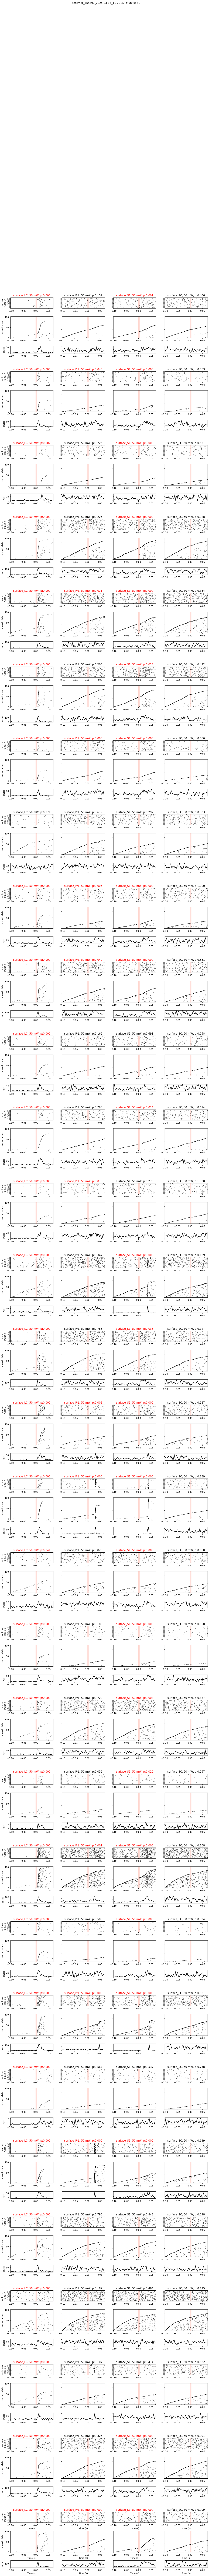

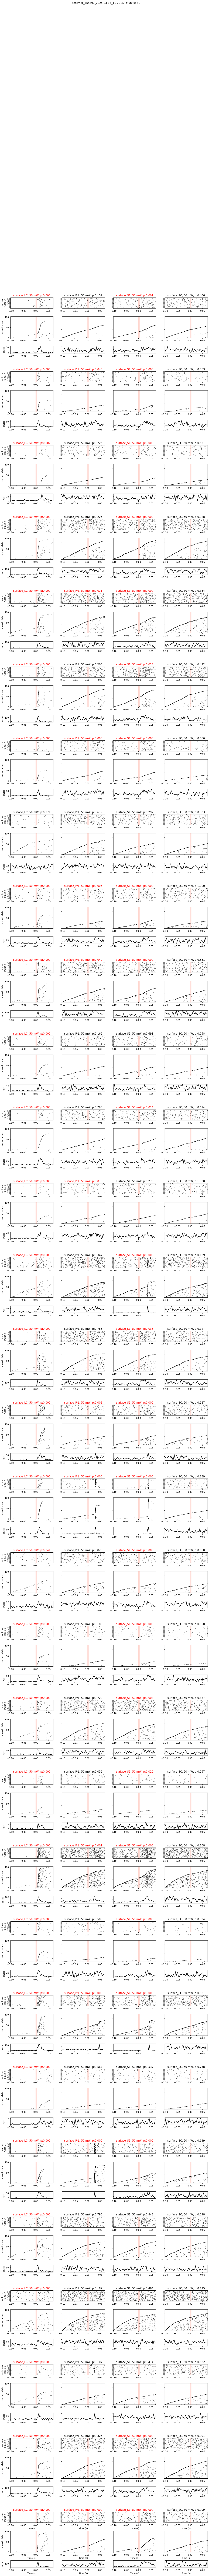

In [8]:
plot_opto_responses(unit_tbl, event_ids, spiketimes, session_id)

Collision test for unit 46 at site surface_S1 with antidromic latency 0.0365 ms
collision boundary -68.02838042378423
Table for Fisher's exact test:
[[np.int64(93), np.int64(158)], [np.int64(53), np.int64(83)]]


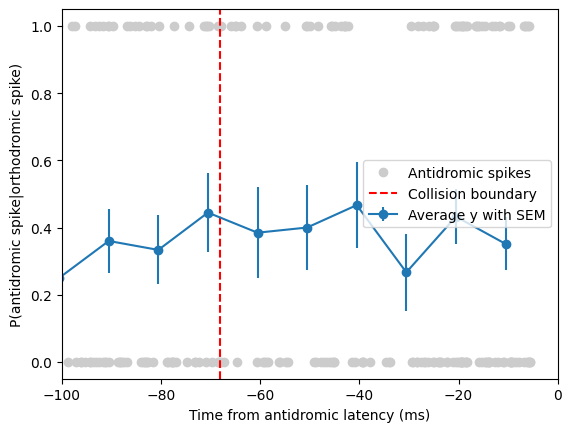

Fisher's exact test p-value: 0.7423
Collision test results: p_value=0.7422902343345739, p_binom=0.0
Collision boundary: -68.03 ms
Pre-boundary probability: 0.37
Post-boundary probability: 0.39



unit_id         p_val                            \
site            surface_LC surface_PrL    surface_S1   
0         46  3.670999e-07    0.347123  4.838563e-34   

     median_first_spike_latency                            jitter              \
site                 surface_LC surface_PrL surface_S1 surface_LC surface_PrL   
0                      0.015066         NaN   0.036514   0.012479         NaN   

                collision_pvalue                        collision_pbinom  \
site surface_S1       surface_LC surface_PrL surface_S1       surface_LC   
0      0.012738              NaN         NaN    0.74229              NaN   

                             
site surface_PrL surface_S1  
0            NaN        0.0

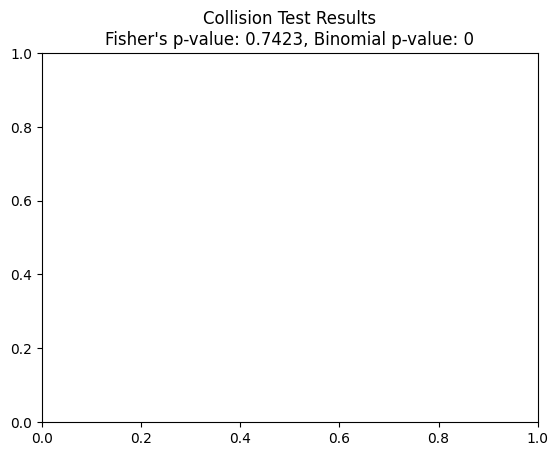

In [9]:
antidromic_results = []
for unit_id in opto_units:
    if unit_id == 46:

        unit_spike_times = spiketimes[unit_id]
        for site in event_ids['site'].unique():
            if site == 'surface_LC':
                base_window = (-0.02, 0)
                roi_window = (0, 0.02)
            else:
                base_window = (-0.02, 0)
                roi_window = (0.03, 0.05)

            tag_trials = event_ids.query('site == @site and pre_post == "post"')
            if tag_trials.empty:
                continue
            max_power = tag_trials.power.max()
            tag_trials = tag_trials.query('power == @max_power')
            if tag_trials.empty:
                continue

            duration = tag_trials.duration.iloc[0]
            num_pulses = tag_trials.num_pulses.iloc[0]
            pulse_interval = tag_trials.pulse_interval.iloc[0]
            time_range_raster = np.array([-100 / 1000, 70 / 1000])
            this_event_timestamps = tag_trials.time.tolist()

            int_event_locked_timestamps = []
            for pulse_num in range(num_pulses):
                time_shift = pulse_num * (duration + pulse_interval) / 1000
                this_time_range = time_range_raster + time_shift
                this_locked = af.event_locked_timestamps(
                    unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift
                )
                int_event_locked_timestamps.extend(this_locked)

            p_val = opto_tagging_response(int_event_locked_timestamps, base_window, roi_window)
            antidromic_results.append({
                'unit_id': unit_id,
                'site': site,
                'p_val': p_val                
            })
            if p_val < 0.05:
                first_spikes_after_light = np.array([arr[arr > 0][0] for arr in int_event_locked_timestamps if np.any(arr > 0)])
                median_first_spikes_after_light = np.median(first_spikes_after_light)
                jitteriness = np.std(first_spikes_after_light)
                antidromic_results[-1]['median_first_spike_latency'] = median_first_spikes_after_light
                antidromic_results[-1]['jitter'] = jitteriness
                antidromic_latency = median_first_spikes_after_light

                if site != 'surface_LC':

                    print(f"Collision test for unit {unit_id} at site {site} with antidromic latency {antidromic_latency:.4f} ms")                    
                    collision_results = collision_test(int_event_locked_timestamps, antidromic_latency, bin_size=10, antidromic_jitter=0.005, plot=True)

                    antidromic_results[-1]['collision_pvalue'] = collision_results['p_value']
                    antidromic_results[-1]['collision_pbinom'] = collision_results['p_binom']
                    print(f"Collision test results: p_value={antidromic_results[-1]['collision_pvalue']}, p_binom={antidromic_results[-1]['collision_pbinom']}")
                    print(f"Collision boundary: {collision_results['collistion_boundary']:.2f} ms")
                    print(f"Pre-boundary probability: {collision_results['pre_boundary_prob']:.2f}")
                    print(f"Post-boundary probability: {collision_results['post_boundary_prob']:.2f}")
                    print()
            if site == 'surface_S1':
                break
                    
                
antidromic_df = pd.DataFrame(antidromic_results)
antidromic_pivot = antidromic_df.pivot(index='unit_id', columns='site').reset_index()
antidromic_pivot              

        



In [141]:
result_folder = '/scratch/antidromic'

# Save figure as pdf
fig.savefig(os.path.join(result_folder, f'{session}_antidromic_raster_summary.pdf'), bbox_inches='tight')   
print(f'Saved figure to {result_folder}/{session}_antidromic_raster_summary.pdf')     


Saved figure to /scratch/antidromic/behavior_758017_2025-02-06_11-26-14_antidromic_raster_summary.pdf


In [28]:
def categorize_units(antidromic_pivot):
    # Flatten MultiIndex columns if needed
    if isinstance(antidromic_pivot.columns, pd.MultiIndex):
        antidromic_pivot.columns = ['_'.join([str(i) for i in col if i]) for col in antidromic_pivot.columns.values]

    # Prepare a DataFrame to collect categorization
    categories = []

    # Iterate over each unit
    for idx, row in antidromic_pivot.iterrows():
        unit_id = row['unit_id']
        tier = None
        # Find all sites except surface_LC
        for col in antidromic_pivot.columns:
            if col.startswith('p_val_') and not col.endswith('surface_LC'):                
                site = col.replace('p_val_', '')
                print(site)
                p_val = row[col]
                jitter_col = f'jitter_{site}'
                jitter = row.get(jitter_col, None)
                if pd.notnull(p_val) and p_val < 0.05:
                    tier = 3
                    if pd.notnull(jitter) and jitter < 0.005:
                        # Candidate for tier 2
                        collision_pvalue_col = f'collision_pvalue_{site}'
                        collision_pbinom_col = f'collision_pbinom_{site}'
                        collision_pvalue = row.get(collision_pvalue_col, None)
                        collision_pbinom = row.get(collision_pbinom_col, None)
                        if pd.notnull(collision_pvalue) and collision_pvalue < 0.05 and collision_pbinom == 1:
                            tier = 1                            
                        else:
                            tier = 2
                        
        if tier is None:
            tier = 0
        categories.append({'unit_id': unit_id, 'tier': tier, 'site': site if tier > 0 else None})    

    return pd.DataFrame(categories)
unit_tiers = categorize_units(antidromic_pivot)
unit_tiers

surface_PrL
surface_S1


unit_id  tier        site
0     49.0     1  surface_S1